[View in Colaboratory](https://colab.research.google.com/github/Berowne/DeepFin/blob/master/FakeNews2.ipynb)

# Recurrent Neural Nets - Fake News

The RNN (LSTM) architechture that we are using is shown below, a many to one RNN.

![RNNs](https://github.com/sachinruk/deepschool.io/blob/master/images/RNN-unrolled.png?raw=true)

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

We achieve 87% accuracy in a test set. However, the article in Second reference claims to have 93% accuracy. The main difference is that they seem to use a Bag of Words Model, which loses the order of words when sending into the ML algorithm. Also

## References:
1. Data: https://github.com/GeorgeMcIntire/fake_real_news_dataset
2. Classification using Scikit Learn: https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/
3. Glove vectors: https://nlp.stanford.edu/projects/glove/



In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/fZ2VS-Okju8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
stopWords = list(stopwords.words('english'))
stopWords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
!wget https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip
!unzip fake_or_real_news.csv.zip

--2018-06-24 07:38:55--  https://github.com/GeorgeMcIntire/fake_real_news_dataset/raw/master/fake_or_real_news.csv.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GeorgeMcIntire/fake_real_news_dataset/master/fake_or_real_news.csv.zip [following]
--2018-06-24 07:38:56--  https://raw.githubusercontent.com/GeorgeMcIntire/fake_real_news_dataset/master/fake_or_real_news.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11878108 (11M) [application/zip]
Saving to: ‘fake_or_real_news.csv.zip.2’

fake_or_real_news.c 100%[===================>]  11.33M  --.-KB/s    in 0.08s   

201

Preprocessing steps: lower case, remove urls, some punctuations etc.

In [14]:
df = pd.read_csv('fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [15]:
df.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)

df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(6335, 2)


,text,label
0,daniel greenfield a shillman journalism fellow...,FAKE
1,google pinterest digg linkedin reddit stumbleu...,FAKE
2,u . s . secretary of state john f . kerry said...,REAL
3,kaydee king kaydeeking november 9 2016 the les...,FAKE
4,its primary day in new york and frontrunners h...,REAL


In [24]:
ps = PorterStemmer()
df.head().text.apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

0    daniel greenfield a shillman journal fellow at...
1    googl pinterest digg linkedin reddit stumbleup...
2    u . s . secretari of state john f . kerri said...
3    kayde king kaydeek novemb 9 2016 the lesson fr...
4    it primari day in new york and frontrunn hilla...
Name: text, dtype: object

In [25]:
df.text = df.text.apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [32]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=20,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(df.text.values)
y = (df.label.values=='REAL').astype('int')

In [30]:
type(tf)

scipy.sparse.csr.csr_matrix

In [33]:
tf.shape

(6335, 7467)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(tf, y, test_size=0.1, random_state=42)

## Many to One LSTM

### Basic Method:
This method is no different to the method utilised in the sentiment analysis lesson.

In [36]:
model = Sequential()
model.add(Dense(units=1, activation='sigmoid', input_dim=tf.shape[1]))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=["binary_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 7468      
Total params: 7,468
Trainable params: 7,468
Non-trainable params: 0
_________________________________________________________________


In [37]:
batch_size = 128
epochs = 5
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 5701 samples, validate on 634 samples
Epoch 1/5
5701/5701 [==============================] - 1s 184us/step - loss: 0.3942 - binary_accuracy: 0.8558 - val_loss: 0.3241 - val_binary_accuracy: 0.9101
Epoch 2/5
5701/5701 [==============================] - 0s 57us/step - loss: 0.2539 - binary_accuracy: 0.9405 - val_loss: 0.2952 - val_binary_accuracy: 0.9132
Epoch 3/5
5701/5701 [==============================] - 0s 59us/step - loss: 0.2181 - binary_accuracy: 0.9532 - val_loss: 0.2799 - val_binary_accuracy: 0.9148
Epoch 4/5
5701/5701 [==============================] - 0s 64us/step - loss: 0.1967 - binary_accuracy: 0.9604 - val_loss: 0.2700 - val_binary_accuracy: 0.9211
Epoch 5/5
5701/5701 [==============================] - 0s 66us/step - loss: 0.1816 - binary_accuracy: 0.9651 - val_loss: 0.2624 - val_binary_accuracy: 0.9196


In [39]:
def transform(string):
  string = string.lower()
  string = ' '.join([ps.stem(word) for word in string.split()])
  return string

In [41]:
sentence = "North korea is testing out missiles on americans living overseas ."
sentence = transform(sentence)
x = tf_vectorizer.transform([sentence])
model.predict(x)

array([[0.45314562]], dtype=float32)

In [42]:
sentence

'north korea is test out missil on american live oversea .'

In [43]:
x.shape

(1, 7467)

In [44]:
sentence = "The chemicals in the water is turning the freaking frogs gay says cnn . "
sentence = transform(sentence)
x = tf_vectorizer.transform([sentence])
model.predict(x)

array([[0.505954]], dtype=float32)

In [45]:
sentence = "President Trump is the greatest president of all time period ."
sentence = transform(sentence)
x = tf_vectorizer.transform([sentence])
model.predict(x)

array([[0.4818339]], dtype=float32)

In [46]:
model.evaluate(X_test, y_test)

634/634 [==============================] - 0s 114us/step


[0.262371898919626, 0.9195583584932875]

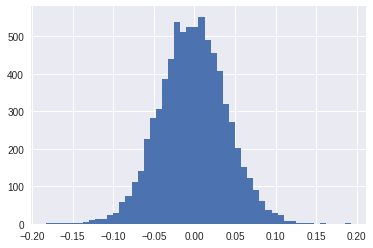

In [52]:
weights = model.get_weights()[0]
plt.hist(weights, 50)
plt.show()

In [59]:
words = np.array(tf_vectorizer.get_feature_names())[:, None]
pos_words = words[weights>0.1]
neg_words = words[weights<-0.1]

In [60]:
pos_words

array(['131', '232', '79', 'analyst', 'backer', 'baltimor', 'bernardino',
       'bin', 'boehner', 'broader', 'carson', 'commonsens', 'conserv',
       'contrast', 'convent', 'coverag', 'cruz', 'demo', 'dismantl',
       'downplay', 'factcheck', 'firstterm', 'freddi', 'friday',
       'frontrunn', 'grappl', 'huckabe', 'infight', 'islamist',
       'kentucki', 'kurtz', 'monday', 'nomin', 'partisan', 'presumpt',
       'ramp', 'reform', 'rhode', 'rtexa', 'runup', 'saturday', 'sen',
       'sheer', 'tech', 'ted', 'tehran', 'thursday', 'todo', 'tougher',
       'trail', 'trustworthi', 'tuesday', 'upstat', 'walker', 'wari',
       'wartim'], dtype='<U17')

In [61]:
neg_words

array(['2016', '27', '28', 'absolut', 'academia', 'advertis', 'articl',
       'caller', 'cc', 'cent', 'civilian', 'com', 'commod', 'copyright',
       'courtesi', 'daili', 'defenc', 'dmca', 'dog', 'euro', 'flickr',
       'genet', 'girl', 'globalist', 'grab', 'implant', 'impun', 'julian',
       'leftright', 'login', 'mainstream', 'min', 'msm', 'naturalnew',
       'navig', 'notifi', 'novemb', 'oct', 'octob', 'onion', 'org', 'pic',
       'pinterest', 'pipelin', 'pleas', 'pm', 'podesta', 'pravda',
       'prostitut', 'psychopath', 'publish', 'recycl', 'repost', 'rock',
       'rt', 'ru', 'sf', 'share', 'sheepl', 'sociabl', 'sourc', 'sputnik',
       'steal', 'subscrib', 'tag', 'templ', 'terri', 'theresa', 'trunew',
       'uk', 'url', 'warmong', 'wikileak', 'youtub'], dtype='<U17')

In [62]:
1

1